<a href="https://colab.research.google.com/github/Doris-QZ/Reproducing-BERT-from-Scratch-with-PyTorch/blob/main/2_Reproducing_BERT_Model_from_Scratch_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook builds the **BERT architecture from scratch in PyTorch** to gain a deeper understanding of how the model works internally. The implementation covers the main building blocks:

* **BERT Embeddings**: positional, token, and segment embedding
* **Transformer Blocks**: multi-head-attention and feed-forward layers
* **Output Layer**: MLM output and NSP output

Finally, the model is trained for **one epoch** on the prepared dataset, and the **training and test loss** are reported to verify that the implementation works end-to-end.


In [ ]:
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import copy

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

import transformers
from transformers import get_linear_schedule_with_warmup

In [ ]:
# Use GPU when it's available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Prepare the Data

First, we load the data processed in the `1. Data For BERT.ipynb` notebook.

In [ ]:
# Load the data
imdb = pd.read_csv('/content/imdb_bert_data.csv', engine='python')

# Take a look at the data
imdb.info()
imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150288 entries, 0 to 150287
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   bert_inputs     150288 non-null  object
 1   bert_labels     150288 non-null  object
 2   segment_labels  150288 non-null  object
 3   is_next         150288 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.6+ MB


,bert_inputs,bert_labels,segment_labels,is_next
0,"[1, 32, 3, 342, 333, 160, 3, 19356, 8, 141, 42...","[0, 32, 22, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,"[1, 24, 200, 23, 1556, 74, 3, 3, 42, 882, 52, ...","[0, 0, 0, 0, 0, 0, 12, 11, 0, 0, 0, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,"[1, 1055, 27, 1648, 6, 996, 19, 61, 7, 2, 1055...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 5,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",1
3,"[1, 221, 103, 3, 86, 28727, 12, 327, 3, 9, 136...","[0, 0, 0, 73, 0, 0, 0, 0, 1863, 0, 0, 0, 0, 0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,"[1, 3, 3, 20, 41, 3782, 42, 9146, 3155, 41, 66...","[0, 54, 45796, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


In [ ]:
import ast

cols = ['bert_inputs', 'bert_labels', 'segment_labels']

# Parse list-like strings in the selected columns into actual Python lists
for col in cols:
    imdb[col] = imdb[col].apply(ast.literal_eval)

type(imdb.iloc[1]['bert_inputs'])

list

The data is stored in a pandas DataFrame. To use it with the BERT model, we need to load it into a PyTorch `DataLoader`. This involves three steps:

1.   Convert the DataFrame into a PyTorch `Dataset`.
2.   Define a custom `collate function`.
3.   Wrap the dataset in a `DataLoader`.

In [ ]:
# Define a BERT_Dataset class
class BERT_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Locate the row in the dataframe using the index
        row = self.data.iloc[idx]

        # Extract values from the row and convert them to torch tensors
        bert_input = torch.tensor(row['bert_inputs'], dtype=torch.long)
        bert_label = torch.tensor(row['bert_labels'], dtype=torch.long)
        segment_label = torch.tensor(row['segment_labels'], dtype=torch.long)
        is_next = torch.tensor(row['is_next'], dtype=torch.long)

        return bert_input, bert_label, segment_label, is_next

In [ ]:
# Split the data into training and test set
imdb_train_df, imdb_test_df = train_test_split(imdb, test_size=0.2, shuffle=False)

# Create BERT_Dataset instances for training and test sets
imdb_train = BERT_Dataset(imdb_train_df)
imdb_test = BERT_Dataset(imdb_test_df)

imdb_train[0]

(tensor([    1,    32,     3,   342,   333,   160,     3, 19356,     8,   141,
            42,   628,   206,     7,     2,    19,    12,   439,    52,   482,
            11,    19,    21,   158,     7,     2,     0,     0,     0,     0]),
 tensor([ 0, 32, 22,  0,  0,  0, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 0, 0, 0, 0]),
 tensor(1))

In [ ]:
# Define a custom collate function
def collate_fn(batch):
    bert_input_batch, bert_label_batch, segment_label_batch, is_next_batch = [], [], [], []

    # Append each input to the respective batch list, truncate sequence longer than 512
    for bert_input, bert_label, segment_label, is_next in batch:
        if len(bert_input) > 512:
            bert_input = bert_input[:512]
            bert_label = bert_label[:512]  # Corrected typo here
            segment_label = segment_label[:512]

        bert_input_batch.append(bert_input)
        bert_label_batch.append(bert_label)
        segment_label_batch.append(segment_label)
        is_next_batch.append(is_next)

    # Pad the sequence in the batch with '[PAD]' index (0)
    bert_input_batch = pad_sequence(bert_input_batch, padding_value=0, batch_first=True)
    bert_label_batch = pad_sequence(bert_label_batch, padding_value=0, batch_first=True)
    segment_label_batch = pad_sequence(segment_label_batch, padding_value=0, batch_first=True)
    is_next_batch = torch.tensor(is_next_batch, dtype=torch.long)

    return bert_input_batch, bert_label_batch, segment_label_batch, is_next_batch

The original BERT paper uses a batch size of 256 in pre-training, but we use 4 here to prevent running out of GPU memory.

In [ ]:
# Wrap the datasets in dataloaders
BATCH_SIZE = 4

train_dataloader = DataLoader(imdb_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(imdb_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 30058
Number of test batches: 7515


### Build the Model

##### **Model Architecture**
The architecture of BERT Model consists of three main components:


1.   **BERT Embedding**:   
Token embedding + Positional Encoding + Segment Embedding (Input token types).

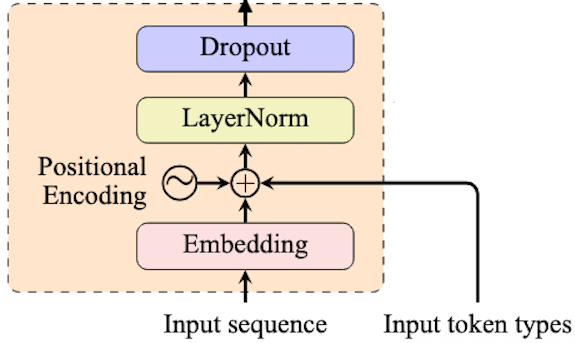

[Image Source](https://machinelearningmastery.com/linear-layers-and-activation-functions-in-transformer-models/)
   
     

2.   **Transformer Block**:   
* (Multi-Head-Attention + Feed-Forward) × num_layers    
* num_layers=12 for BERT_base, and 24 for BERT_large.  

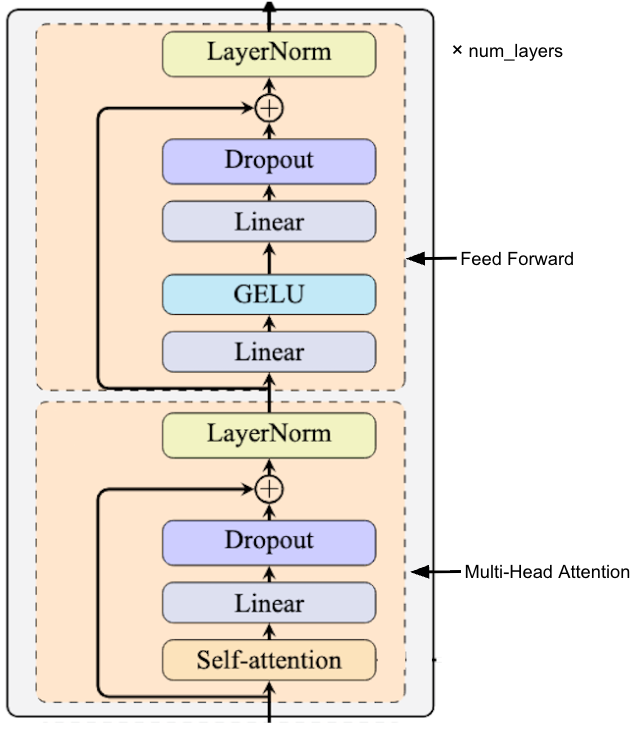

[Image Soure](https://machinelearningmastery.com/linear-layers-and-activation-functions-in-transformer-models/)

3.   **Output Layer**:   
* Masked LM(Masked Language Modeling) output
* NSP(Next Sentence Prediction) output.   

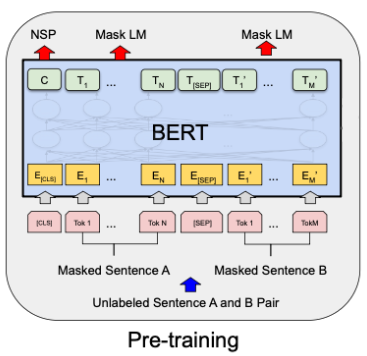

[Image Source](https://arxiv.org/abs/1810.04805)



##### **Model Parameters**

We set the parameters of all modules to match the **BERT-base** model described in the original BERT paper:

* Maximum sequence length: **512**

* Hidden size (embedding dimension): **768**

* Number of self-attention heads: **12**

* Number of layers (Transformer blocks): **12**

* Dropout rate: **0.1**

* Feed-forward size: **3072**


In [ ]:
# Create Positional_Encoding class for BERT Embeddings
class Positional_Encoding(nn.Module):
    def __init__(self, max_seq_len=512, d_model=768):
        super().__init__()

        # Create a positional encoding matrix of shape: [max_seq_len, embedding_dim]
        pe = torch.zeros(max_seq_len, d_model)

        # Create a position vector of shape: [max_seq_len, 1]
        pos = torch.arange(max_seq_len).unsqueeze(1)

        # Create the division term
        div = torch.exp(
            -torch.arange(0, d_model, 2)/ d_model  * math.log(10000.0)
        )

        # Apply sin and cos to even and odd indices respectively
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)

        # Add batch dimension. pe shape: [1, max_seq_len, embedding_dim]
        pe = pe.unsqueeze(0)

        # Register a buffer named 'positional_encoding' (non-learnable)
        self.register_buffer('positional_encoding', pe)

    def forward(self, x):
        # x shape: [batch_size, seq_length, embedding_dim]
        return self.positional_encoding[:, :x.shape[1]]


In [ ]:
# Create Multi_Head_Attention class for Transformer Block
class Multi_Head_Attention(nn.Module):
    # Set the parameters to align with the BERT base model
    def __init__(self, num_heads=12, d_model=768, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads     # head size of each scaled dot-product attention

        # Linear projection for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Linear projection for the concatenated scaled_dot_product_attention
        self.W_o = nn.Linear(d_model, d_model)

        # Dropout and Layer norm
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V shape: [batch_size, num_heads, seq_length, d_k]

        # Calculate attention score, shape: [batch_size, num_heads, seq_length, seq_length]
        attn_score = Q @ torch.transpose(K, -2, -1) / math.sqrt(self.d_k)

        # Apply mask if provided:
        if mask is not None:
            attn_score = attn_score.masked_fill(mask==0, -1e9)

        # Apply softmax to get attention weight
        attn_weight = attn_score.softmax(dim=-1)   # attn_weight shape: [batch_size, num_heads, seq_length, seq_length]

        # Attention output
        attn_output = attn_weight @ V       # attn_output shape: [batch_size, num_heads, seq_length, d_k]

        return attn_output

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_length, d_model]

        batch_size = x.shape[0]

        # Linear projection and reshape
        # Q, K, V shape: [batch_size, num_heads, seq_length, d_k]
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Get scaled dot-product attention output, shape: [batch_size, num_heads, seq_length, d_k]
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask=mask)

        # Reshape attention output(akin to concat mutliple scaled dot-product attention heads)
        # concat_output shape: [batch_size, seq_length, d_model]
        concat_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Linear projection and dropout
        output = self.dropout(self.W_o(concat_output))    # output shape: [batch_size, seq_length, d_model]

        # Add & Norm
        output = self.layer_norm(x + output)              # output shape: [batch_size, seq_length, d_model]

        return output


In [ ]:
# Create Feed_Forward class for Transformer Block
class Feed_Forward(nn.Module):
    def __init__(self, d_model=768, d_ff=3072, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]

        output = self.gelu(self.linear1(x))              # output shape: [batch_size, seq_length, d_ff]
        output = self.dropout(self.linear2(output))      # output shape: [batch_size, seq_length, d_model]
        output = self.layer_norm(x + output)             # output shape: [batch_size, seq_length, d_model]

        return output

In [ ]:
# Create Transformer_Encoder class (one layer of Transformer Block)
class Transformer_Encoder(nn.Module):
    def __init__(self, num_heads=12, d_model=768, d_ff=3072, dropout=0.1):
        super().__init__()
        self.multi_head_Attn = Multi_Head_Attention(num_heads, d_model, dropout)
        self.feed_forward = Feed_Forward(d_model, d_ff, dropout)

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_length, d_model]

        output = self.multi_head_Attn(x, mask=mask)
        output = self.feed_forward(output)

        return output     # output shape: [batch_size, seq_length, d_model]

In [ ]:
# Create BERT_Model class
class BERT_Model(nn.Module):
    def __init__(self, vocab_size, num_layers=12, num_heads=12, d_model=768, d_ff=3072, max_seq_len=512, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = Positional_Encoding(max_seq_len, d_model)
        self.segment_embedding = nn.Embedding(3, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.mlm_linear = nn.Linear(d_model, vocab_size)
        self.nsp_linear = nn.Linear(d_model, 2)

        transformer_layer = Transformer_Encoder(num_heads, d_model, d_ff, dropout)
        self.transformer_block = nn.ModuleList([copy.deepcopy(transformer_layer) for _ in range(num_layers)])

    def forward(self, bert_input, segment_label, mask=None):
        # input shape: [batch_size, seq_length]

        # BERT Embedding
        token_embedding = self.token_embedding(bert_input) * math.sqrt(self.d_model)
        positional_encoding = self.positional_encoding(token_embedding)
        segment_embedding = self.segment_embedding(segment_label)
        bert_embedding = token_embedding + positional_encoding + segment_embedding  # bert_embedding shape: [batch_size, seq_length, d_model]

        output = self.dropout(self.layer_norm(bert_embedding))

        # Transformer Blocks
        for encoder in self.transformer_block:
            output = encoder(output, mask=mask)     # output shape: [batch_size, seq_length, d_model]

        # Output Layer - Masked Language Modeling
        mlm_output = self.mlm_linear(output)        # mlm_output shape: [batch_size, seq_length, vocab_size]

        # Output Layer - Next Sentence Prediction (use [CLS] embedding for the prediction)
        nsp_output = self.nsp_linear(output[:, 0, :])  # nsp_output shape: [batch_size, 2]

        return mlm_output, nsp_output

The BERT paper uses WordPiece, a sub-word tokenization algorithm, with a vocabulary of 30,000 token. In this project, however, the IMDB dataset was prepared using NLTK’s word-based tokenizer, resulting in a vocabulary size of 132,093.

In [ ]:
# Instantiate a BERT model
model = BERT_Model(vocab_size=132093).to(device)

# Define the optimizer
optimizer = Adam(params=model.parameters(),
                 lr=1e-4,
                 weight_decay=0.01)

# Define the learning rate schedule
EPOCHS = 1
training_steps = EPOCHS * len(train_dataloader)
warmup_steps = int(training_steps * 0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=training_steps)

# Define the loss function
mlm_loss = nn.CrossEntropyLoss(ignore_index=0)    # ignore '[PAD]' index
nsp_loss = nn.CrossEntropyLoss()

In [ ]:
# Define the training loop
def training_loop(model, train_dataloader, test_dataloader, optimizer, lr_scheduler, mlm_loss_fn, nsp_loss_fn, epochs):
    history = {'train_loss': [],
               'test_loss': []}

    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        train_loss = 0

        # Iterate through the train_dataloader
        for i, data in enumerate(train_dataloader):
            bert_input = data[0].to(device)
            bert_label = data[1].to(device)
            segment_label = data[2].to(device)
            is_next = data[3].to(device)

            # Reset the gradients of the model's parameters to zero
            optimizer.zero_grad()

            # Forward pass
            mlm_output, nsp_output = model(bert_input, segment_label)

            # Calculate the train loss
            mlm_loss = mlm_loss_fn(mlm_output.view(-1, mlm_output.shape[-1]), bert_label.view(-1))
            nsp_loss = nsp_loss_fn(nsp_output, is_next)
            loss = mlm_loss + nsp_loss
            train_loss += loss.item()

            # Back propagation(computes the gradients)
            loss.backward()

            # Clip the gradient norm of the parameters to prevent the exploding gradient problem
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Updates the model's parameters based on the gradients
            optimizer.step()

            # Updates the learning rate of the optimizer based on the predefined schedule
            lr_scheduler.step()

        train_loss /= len(train_dataloader)
        history['train_loss'].append(train_loss)

        # Set model to evaluation mode
        model.eval()
        test_loss = 0

        # Iterate through the test_dataloader
        for i, data in enumerate(test_dataloader):
            bert_input = data[0].to(device)
            bert_label = data[1].to(device)
            segment_label = data[2].to(device)
            is_next = data[3].to(device)

            # Forward pass
            mlm_output, nsp_output = model(bert_input, segment_label)

            # Calculate the test loss
            mlm_loss = mlm_loss_fn(mlm_output.view(-1, mlm_output.shape[-1]), bert_label.view(-1))
            nsp_loss = nsp_loss_fn(nsp_output, is_next)
            loss = mlm_loss + nsp_loss
            test_loss += loss.item()

        test_loss /= len(test_dataloader)
        history['test_loss'].append(test_loss)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    return history

In [ ]:
# Train the model for one epoch and print out the training and test loss
history = training_loop(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        lr_scheduler=lr_scheduler,
                        mlm_loss_fn=mlm_loss,
                        nsp_loss_fn=nsp_loss,
                        epochs=EPOCHS)


Epoch 0 | Train Loss: 8.5549 | Test Loss: 8.4288


In [ ]:
history

{'train_loss': [8.554909365374977], 'test_loss': [8.428779411760077]}